# Introduction: Solving the 2D Poisson Equation

## 1. Physical and Mathematical Context

The **Poisson equation** is a fundamental partial differential equation (PDE) used across physics and engineering to describe how a field (like electric potential or temperature) behaves in the presence of a source (like electric charge or heat).

In two dimensions, the equation for electric potential $V$ is:

$$\nabla^2 V = \frac{\partial^{2}V}{\partial x^{2}} + \frac{\partial^{2}V}{\partial y^{2}} = -\frac{\rho(x,y)}{\epsilon}$$

Where:

*   **$\nabla^2$ (The Laplacian):** Represents the "curvature" or spatial second derivative of the potential.
*   **$\rho(x,y)$:** The charge density (the source). In this project, we use a specific Gaussian distribution: 
    $$\rho(x,y) = \rho_0 \exp\left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right)$$
*   **$\epsilon$:** The permittivity of the medium (assumed to be 1.0 for simplicity).

If the source term $\rho$ is zero, the equation is known as the **Laplace equation**, which describes the potential in a region "empty" of charges:
$$\frac{\partial^{2}V}{\partial x^{2}} + \frac{\partial^{2}V}{\partial y^{2}} = 0$$

## 2. Boundary Conditions (BCs)

To find a unique solution within a square domain $\Omega$, we must define what happens at the edges $\partial \Omega$:

1.  **Dirichlet Boundary Conditions:** We explicitly set the value of the potential $V$ at the edge. Here, we use sinusoidal functions (controlled by parameters $A$ through $D$) to simulate varying potentials along the four walls:
    $$V(x, y) = f(x, y) \quad \text{for} \quad (x, y) \in \partial \Omega$$
2.  **Neumann Boundary Conditions:** We set the *gradient* (slope) of the potential. For example, setting $\frac{\partial V}{\partial n} = 0$ on the right boundary simulates an insulating or reflective boundary:
    $$\nabla V \cdot \mathbf{n} = \frac{\partial V}{\partial n} = g(x, y)$$

## 3. The Numerical Approach: Successive Over-Relaxation (SOR)

To solve the Poisson equation numerically, we transform the continuous partial differential equation into a discrete system of algebraic equations. This process is known as the **Finite Difference Method (FDM)**.

### 1) Discretization of the Domain

We represent the continuous $xy$-plane as a grid (or mesh) of points. If the square domain has length $L$, we divide it into $N$ intervals along each axis, resulting in a grid spacing $h$:

$$h = \Delta x = \Delta y = \frac{L}{N}$$

A point in the domain is now identified by integer indices $(i, j)$, where the coordinates are:
$$x_i = i \cdot h, \quad y_j = j \cdot h$$

The continuous potential $V(x,y)$ is transformed into a discrete matrix $V_{i,j}$, where each entry represents the potential value at a specific grid node.

### 2) Finite Difference Approximation

To handle the second-order derivatives $\frac{\partial^2 V}{\partial x^2}$ and $\frac{\partial^2 V}{\partial y^2}$, we use the **Taylor Series expansion**. By combining the forward and backward expansions, we derive the **Central Difference Formula**:

$$\frac{\partial^2 V}{\partial x^2} \approx \frac{V_{i+1,j} - 2V_{i,j} + V_{i-1,j}}{h^2}$$
$$\frac{\partial^2 V}{\partial y^2} \approx \frac{V_{i,j+1} - 2V_{i,j} + V_{i,j-1}}{h^2}$$

Substituting these into the Poisson equation ($\nabla^2 V = -\rho/\epsilon$) gives the **Five-Point Stencil**:

$$\frac{V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1} - 4V_{i,j}}{h^2} = -\frac{\rho_{i,j}}{\epsilon}$$

### 3) From Algebra to Iterative Schemes

If we solve the stencil equation for the central point $V_{i,j}$, we find that the potential at any point is the average of its four neighbors plus a correction for the local charge density:

$$V_{i,j} = \frac{1}{4} \left( V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1} + \frac{h^2 \rho_{i,j}}{\epsilon} \right)$$

Because every point depends on its neighbors, we cannot solve for $V_{i,j}$ directly in one step. Instead, we use the **Gauss-Seidel** approach, where we sweep through the grid and update values using the most recent data available:

$$V_{i,j}^{\text{new}} = \frac{1}{4} \left( V_{i+1,j}^{\text{old}} + V_{i-1,j}^{\text{new}} + V_{i,j+1}^{\text{old}} + V_{i,j-1}^{\text{new}} + \frac{h^2 \rho_{i,j}}{\epsilon} \right)$$

### 4) Successive Over-Relaxation (SOR) Logic

The **Successive Over-Relaxation (SOR)** method accelerates convergence by looking at the "residual" (the difference between the current value and the calculated target) and amplifying the update.

We define the update as a weighted average between the old value and the Gauss-Seidel target using a relaxation factor $\omega$:

$$V_{i,j}^{(k+1)} = (1 - \omega)V_{i,j}^{(k)} + \omega V_{i,j}^{\text{GS target}}$$

*   **If $\omega = 1$:** The method is identical to Gauss-Seidel.
*   **If $1 < \omega < 2$ (Over-relaxation):** The algorithm pushes the value further than the local average suggests, which effectively "propagates" information across the grid much faster.
*   **Optimal $\omega$:** For a square grid of size $N$, the optimal value is approximately:
    $$\omega_{\text{opt}} \approx \frac{2}{1 + \sin(\pi/N)}$$

### 5) Convergence Criteria and Energy Functional

The numerical solver iterates until the system reaches a steady state. We monitor the **Energy Functional ($J$)**, which represents the total energy stored in the electrostatic field:

$$J[V] = \int_{\Omega} \left[ \frac{1}{2} |\nabla V|^2 - \frac{\rho}{\epsilon}V \right] dx dy$$

In the discrete version, the algorithm stops when the change in $V$ between two iterations (the $L_\infty$ norm of the residual) falls below a predefined tolerance:
$$\max |V_{i,j}^{(k+1)} - V_{i,j}^{(k)}| < \text{tol}$$

## 4. Physics-Informed Neural Networks (PINNs) vs. Numerical Methods

This project compares the traditional **SOR method** against a modern machine learning approach: **Physics-Informed Neural Networks (PINNs)**.

| Feature        | Numerical (SOR)                   | PINNs (Deep Learning)                          |
| :------------- | :-------------------------------- | :--------------------------------------------- |
| **Space**      | Discrete grid (Nodes)             | Continuous domain                              |
| **Mechanism**  | Iterative local updates           | Loss function minimization via Backpropagation |
| **Physics**    | Hard-coded via finite differences | Embedded in the Neural Network's Loss Function |
| **Efficiency** | Very fast for simple 2D grids     | Slower training, but mesh-free and scalable    |

The PINN minimizes a composite loss function $\mathcal{L}$:
$$\mathcal{L} = \mathcal{L}_{residual} + \mathcal{L}_{BC}$$
Where the residual loss enforces the physics:
$$\mathcal{L}_{residual} = \frac{1}{N} \sum_{i=1}^{N} \left| \frac{\partial^2 \hat{V}}{\partial x^2} + \frac{\partial^2 \hat{V}}{\partial y^2} + \frac{\rho}{\epsilon} \right|^2$$

By comparing the **Potential $V$** and the **Residual $R$** (how much the solution fails to satisfy the original equation), we can determine the accuracy and reliability of neural networks in solving classical electrostatic problems compared to time-tested numerical solvers.

# Numerical Solution (Successive Overrelaxation method)

In [37]:
import numpy as np
import os
import math
import sys

In [38]:

# Try to import Numba for C++ like speed.
# If not installed, it falls back to standard Python (which is slower).
try:
    from numba import jit
    HAS_NUMBA = True
except ImportError:
    HAS_NUMBA = False
    # Dummy decorator if numba is not present
    def jit(nopython=True):
        def decorator(func):
            return func
        return decorator


In [39]:

print(f"Numba acceleration: {'ENABLED' if HAS_NUMBA else 'DISABLED (Install numba for faster execution)'}")

@jit(nopython=True)
def compute_residual_jit(v, rho, N, delta, eps):
    """
    Computes the max residual.
    Optimized with JIT if available.
    """
    max_res = 0.0
    # Create a zero array for R (to mimic the passed reference in C++)
    R = np.zeros_like(v)

    for i in range(1, N - 1):
        for j in range(1, N - 1):
            res = (v[i+1, j] - 2*v[i, j] + v[i-1, j]) / (delta**2) + \
                  (v[i, j+1] - 2*v[i, j] + v[i, j-1]) / (delta**2) + \
                  rho[i, j] / eps
            R[i, j] = res
            max_res = max(max_res, abs(res))

    return max_res, R


Numba acceleration: DISABLED (Install numba for faster execution)


In [40]:

@jit(nopython=True)
def sor_iteration_jit(v, rho, N, delta, eps, omega, use_neumann_right):
    """
    Performs a single iteration of the SOR update loop.
    This is separated to allow Numba to optimize the heavy lifting.
    """
    # Neumann BC: Right boundary (x_max, corresponding to index N-1)
    # The C++ code sets v[N-1][j] = v[N-2][j]
    if use_neumann_right:
        for j in range(N):
            v[N-1, j] = v[N-2, j]

    # Main SOR Loop
    # Note: We iterate 1 to N-1 (exclusive of N-1)
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            v[i, j] = (1 - omega) * v[i, j] + (omega / 4.0) * (
                v[i+1, j] + v[i-1, j] + v[i, j+1] + v[i, j-1] +
                (rho[i, j] * delta**2) / eps
            )
    return v


In [41]:

@jit(nopython=True)
def compute_energy_jit(v, rho, N, delta, eps):
    """
    Computes the energy functional S.
    """
    S = 0.0
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            Ex = -(v[i+1, j] - v[i-1, j]) / (2 * delta)
            Ey = -(v[i, j+1] - v[i, j-1]) / (2 * delta)

            term = (0.5 * (Ex**2 + Ey**2) - v[i, j] * rho[i, j] / eps) * (delta**2)
            S += term
    return S

def run_sor(N, L, eps, Arho, k1, k2, k3, k4, omega, TOL, Kmax,
            use_neumann_right, potential_file, residual_file, convergence_file=""):

    delta = 2.0 * L / (N - 1)
    Vmax = 1.0

    # Grid setup
    x = np.linspace(-L, L, N)
    y = np.linspace(-L, L, N)

    # Initialize Potentials (v) and Density (rho)
    v = np.zeros((N, N))
    rho = np.zeros((N, N))

    # --- Setup rho ---
    # Using loops to match C++ logic exactly, though numpy vectorization is possible
    for i in range(N):
        for j in range(N):
            rho[i, j] = Arho * x[i] * y[j] * math.exp(-(x[i]**2 + y[j]**2))

    # --- Dirichlet BCs ---
    # C++: v[0][j] (Left/x_min), v[N-1][j] (Right/x_max)
    # C++: v[i][0] (Bottom/y_min), v[i][N-1] (Top/y_max)

    for j in range(N):
        # x = -L (index 0)
        v[0, j] = Vmax * math.sin(k1 * math.pi * (y[j] + L) / (2 * L))
        # x = +L (index N-1)
        v[N-1, j] = Vmax * math.sin(k3 * math.pi * (y[j] + L) / (2 * L))

    for i in range(N):
        # y = -L (index 0)
        v[i, 0] = Vmax * math.sin(k4 * math.pi * (x[i] + L) / (2 * L))
        # y = +L (index N-1)
        v[i, N-1] = Vmax * math.sin(k2 * math.pi * (x[i] + L) / (2 * L))

    # Open convergence file if requested
    conv_data = []

    s_old = 0.0
    s_new = 0.0

    print(f"Starting SOR... (omega={omega})")

    # --- SOR Loop ---
    for it in range(1, Kmax + 1):

        # Run Iteration (JIT compiled for speed if numba installed)
        v = sor_iteration_jit(v, rho, N, delta, eps, omega, use_neumann_right)

        # Calculate Energy Functional S
        s_new = compute_energy_jit(v, rho, N, delta, eps)

        # Check Convergence
        if it == 1:
            change = abs(s_new - s_old)
        else:
            # Avoid division by zero if s_new is 0 (unlikely but safe)
            change = abs((s_new - s_old) / s_new) if s_new != 0 else 0

        if convergence_file:
            conv_data.append(f"{it},{s_new},{change}\n")

        # Logging
        if it % 500 == 0 or it == 1:
            print(f"iter {it}   S = {s_new:.6f}   change = {change:.4e}")

        if it > 1 and change < TOL:
            print(f"Converged at iteration {it} (change={change:.4e})\n")
            break

        s_old = s_new

    # --- Compute Residuals ---
    max_res, R = compute_residual_jit(v, rho, N, delta, eps)
    print(f"Max residual = {max_res}\n")

    # --- File Output ---
    # Python generic write to match C++ output format: x, y, value
    # Flattening logic for writing
    print(f"Writing {potential_file}...")
    with open(potential_file, 'w') as f:
        for i in range(N):
            for j in range(N):
                f.write(f"{x[i]},{y[j]},{v[i, j]}\n")

    print(f"Writing {residual_file}...")
    with open(residual_file, 'w') as f:
        for i in range(N):
            for j in range(N):
                f.write(f"{x[i]},{y[j]},{R[i, j]}\n")

    if convergence_file and conv_data:
        with open(convergence_file, 'w') as f:
            f.writelines(conv_data)

    return s_new



In [42]:

def main():
    N = 100
    L = 4.0
    eps = 1.0
    TOL = 1e-8
    Kmax = 10000

    # Task 1
    print("\n--- Task 1 ---")
    run_sor(N, L, eps, 0.0, 1, -1, 1, -1, 1.5, TOL, Kmax, False,
            f"num_data/potential_task1.csv", f"num_data/residual_task1.csv")

    # Task 2
    print("\n--- Task 2 ---")
    run_sor(N, L, eps, 0.0, 1, -1, 1, -1, 1.5, TOL, Kmax, True,
            f"num_data/potential_task2.csv", f"num_data/residual_task2.csv")

    # Task 3
    print("\n--- Task 3 ---")
    omegas = [1.0, 1.3, 1.6, 1.9]
    for w in omegas:
        base = f"num_data/task3_omega_{w}"
        run_sor(N, L, eps, 0.0, 1, -1, 1, -1, w, TOL, Kmax, True,
                f"{base}_potential.csv", f"{base}_residual.csv", f"{base}_convergence.csv")

    # Task 4a
    print("\n--- Task 4a ---")
    run_sor(N, L, eps, 1.0, 0, 0, 0, 0, 1.5, TOL, Kmax, False,
            f"num_data/potential_task4a.csv", f"num_data/residual_task4a.csv")

    # Task 4b
    print("\n--- Task 4b ---")
    run_sor(N, L, eps, 1.0, 1, -1, 1, -1, 1.5, TOL, Kmax, False,
            f"num_data/potential_task4b.csv", f"num_data/residual_task4b.csv")

if __name__ == "__main__":
    main()


--- Task 1 ---
Starting SOR... (omega=1.5)
iter 1   S = 24.819805   change = 2.4820e+01
iter 500   S = 4.696065   change = 6.0378e-08
Converged at iteration 539 (change=9.7155e-09)

Max residual = 0.0015651185951086471

Writing num_data/potential_task1.csv...
Writing num_data/residual_task1.csv...

--- Task 2 ---
Starting SOR... (omega=1.5)
iter 1   S = 16.391259   change = 1.6391e+01
iter 500   S = 2.899805   change = 1.1362e-04
iter 1000   S = 2.825180   change = 1.8034e-05
iter 1500   S = 2.813744   change = 2.7273e-06
iter 2000   S = 2.812046   change = 3.9048e-07
iter 2500   S = 2.811812   change = 4.7778e-08
Converged at iteration 2808 (change=9.9936e-09)

Max residual = 0.0006228882407463518

Writing num_data/potential_task2.csv...
Writing num_data/residual_task2.csv...

--- Task 3 ---
Starting SOR... (omega=1.0)
iter 1   S = 17.886340   change = 1.7886e+01
iter 500   S = 3.135316   change = 1.8575e-04
iter 1000   S = 2.972647   change = 6.8863e-05
iter 1500   S = 2.897245   ch

## Numerical Visualization

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob


In [ ]:
import os  # Make sure this is imported

def plot_heatmap(csv_file, title, output_file=None, cmap='seismic'):
    csv_file = f"num_data/{csv_file}"
    output_file = f"num_plots/{output_file}" if output_file else None
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    # Check if directory exists for the output file, if not, create it
    if output_file:
        # Extract directory name from the file path (e.g., 'num_plots' from 'num_plots/image.png')
        directory = os.path.dirname(output_file)
        # If a directory is specified and it doesn't exist, create it
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory: {directory}")

    print(f"Plotting {csv_file}...")

    try:
        df = pd.read_csv(csv_file, header=None, names=['x', 'y', 'val'])
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")
        return

    grid = df.pivot(index='y', columns='x', values='val')
    x_min, x_max = df['x'].min(), df['x'].max()
    y_min, y_max = df['y'].min(), df['y'].max()

    plt.figure(figsize=(6, 5))
    plt.imshow(grid, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap=cmap, aspect='auto')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300)
        print(f"Saved to {output_file}")
    else:
        plt.show()
    plt.close()

In [83]:

def plot_convergence(csv_files, labels, title, output_file=None):
    """
    Reads multiple convergence CSV files (iter, S, change) and plots them on a log-scale.
    """
    # output_file = f"num_plots/{output_file}"
    plt.figure(figsize=(8, 6))

    for file, label in zip(csv_files, labels):
        file = f"num_data/{file}"
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue

        try:
            # Assuming format: iter, S, change
            df = pd.read_csv(file, header=None, names=['iter', 'S', 'change'])
            plt.plot(df['iter'], df['change'], label=label)
        except Exception as e:
            print(f"Error reading {file}: {e}")

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Relative Change $\delta$')
    plt.title(title)
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend()

    if output_file:
        plt.savefig(output_file, dpi=300)
        print(f"Saved to {output_file}")
        plt.show()
    else:
        plt.show()
    plt.close()


<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_76397/638589063.py:24: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('Relative Change $\delta$')


<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_76397/1741437710.py:22: SyntaxWarning: invalid escape sequence '\o'
  labels = [f"$\omega = {w:.1f}$" for w in omegas]
/tmp/ipykernel_76397/1741437710.py:26: SyntaxWarning: invalid escape sequence '\o'
  plot_convergence(conv_files, labels, 'Convergence Rate for different $\omega$', 'plot_task3_convergence.png')


Plotting num_data/potential_task1.csv...
Saved to plot_task1_potential.png
Plotting num_data/residual_task1.csv...
Saved to plot_task1_error.png
Plotting num_data/potential_task2.csv...
Saved to plot_task2_potential.png
Plotting num_data/residual_task2.csv...
Saved to plot_task2_error.png
Plotting num_data/potential_task4a.csv...
Saved to plot_task4a_potential.png
Plotting num_data/residual_task4a.csv...
Saved to plot_task4a_error.png
Plotting num_data/potential_task4b.csv...
Saved to plot_task4b_potential.png
Plotting num_data/residual_task4b.csv...
Saved to plot_task4b_error.png
File not found: num_data/num_data/task3_omega_1.0_convergence.csv
File not found: num_data/num_data/task3_omega_1.3_convergence.csv
File not found: num_data/num_data/task3_omega_1.6_convergence.csv
File not found: num_data/num_data/task3_omega_1.9_convergence.csv


/tmp/ipykernel_76397/638589063.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Saved to plot_task3_convergence.png


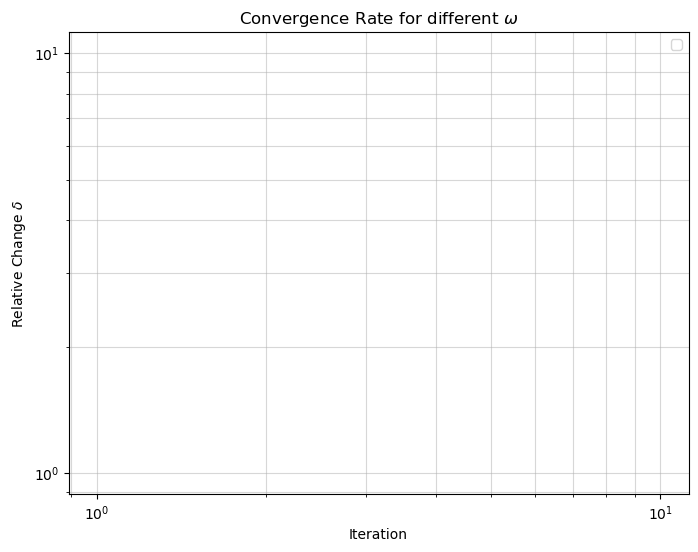

In [84]:

def main():
    # --- Task 1 Plots ---
    plot_heatmap('potential_task1.csv', 'Potential V(x,y) - Task 1', 'plot_task1_potential.png', cmap='bwr')
    plot_heatmap('residual_task1.csv', 'Error (Residual) - Task 1', 'plot_task1_error.png', cmap='bwr')

    # --- Task 2 Plots ---
    plot_heatmap('potential_task2.csv', 'Potential V(x,y) - Task 2', 'plot_task2_potential.png', cmap='bwr')
    plot_heatmap('residual_task2.csv', 'Error (Residual) - Task 2', 'plot_task2_error.png', cmap='bwr')

    # --- Task 4a Plots ---
    plot_heatmap('potential_task4a.csv', 'Potential V(x,y) - Task 4a', 'plot_task4a_potential.png', cmap='bwr')
    plot_heatmap('residual_task4a.csv', 'Error (Residual) - Task 4a', 'plot_task4a_error.png', cmap='bwr')

    # --- Task 4b Plots ---
    plot_heatmap('potential_task4b.csv', 'Potential V(x,y) - Task 4b', 'plot_task4b_potential.png', cmap='bwr')
    plot_heatmap('residual_task4b.csv', 'Error (Residual) - Task 4b', 'plot_task4b_error.png', cmap='bwr')

    # --- Task 3 Convergence Comparison ---
    # Look for files generated by the loop in the previous code
    omegas = [1.0, 1.3, 1.6, 1.9]
    conv_files = [f"num_data/task3_omega_{w:.1f}_convergence.csv" for w in omegas]
    labels = [f"$\omega = {w:.1f}$" for w in omegas]

    # Check if files exist before plotting
    if any(os.path.exists(f) for f in conv_files):
        plot_convergence(conv_files, labels, 'Convergence Rate for different $\omega$', 'plot_task3_convergence.png')
    else:
        print("Convergence files for Task 3 not found. Run the simulation first.")

if __name__ == "__main__":
    main()

# PINN Approach

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os


In [86]:

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        return self.net(inputs)


Running on: cpu


In [87]:

def compute_derivatives(model, x, y):
    """
    Computes V and its first and second derivatives using Autograd.
    Ensures inputs are tracked for gradients.
    """
    # Force gradient tracking on inputs if not already set
    if not x.requires_grad: x.requires_grad_(True)
    if not y.requires_grad: y.requires_grad_(True)

    V = model(x, y)

    # First derivatives
    grads = torch.autograd.grad(V, [x, y], grad_outputs=torch.ones_like(V),
                                create_graph=True, retain_graph=True)
    dV_dx, dV_dy = grads[0], grads[1]

    # Second derivatives
    d2V_dx2 = torch.autograd.grad(dV_dx, x, grad_outputs=torch.ones_like(dV_dx),
                                  create_graph=True, retain_graph=True)[0]
    d2V_dy2 = torch.autograd.grad(dV_dy, y, grad_outputs=torch.ones_like(dV_dy),
                                  create_graph=True, retain_graph=True)[0]

    return V, dV_dx, dV_dy, d2V_dx2, d2V_dy2


In [88]:

def get_boundary_data(N_b, L, Vmax, k_vals, bc_type_right='dirichlet'):
    k1, k2, k3, k4 = k_vals

    pos = torch.rand(N_b, 1) * 2 * L - L
    const = torch.ones_like(pos)

    d_l = (-L*const, pos, Vmax * torch.sin(k1 * np.pi * (pos + L) / (2 * L)))

    target_r = Vmax * torch.sin(k3 * np.pi * (pos + L) / (2 * L)) if bc_type_right == 'dirichlet' else torch.zeros_like(pos)
    d_r = (L*const, pos, target_r)

    d_b = (pos, -L*const, Vmax * torch.sin(k4 * np.pi * (pos + L) / (2 * L)))
    d_t = (pos, L*const, Vmax * torch.sin(k2 * np.pi * (pos + L) / (2 * L)))

    return {'left': d_l, 'right': d_r, 'bottom': d_b, 'top': d_t}


In [89]:

def get_collocation_points(N_c, L):
    x_c = (torch.rand(N_c, 1) * 2 * L - L).to(device)
    y_c = (torch.rand(N_c, 1) * 2 * L - L).to(device)
    return x_c, y_c


In [90]:

def save_results_with_residual(model, history, task_name, L, Arho, epsilon):
    N_plot = 100
    x_np = np.linspace(-L, L, N_plot)
    y_np = np.linspace(-L, L, N_plot)
    X, Y = np.meshgrid(x_np, y_np)

    x_tensor = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    x_tensor.requires_grad_(True)
    y_tensor.requires_grad_(True)

    V_flat, _, _, d2V_dx2, d2V_dy2 = compute_derivatives(model, x_tensor, y_tensor)
    rho_flat = Arho * x_tensor * y_tensor * torch.exp(-(x_tensor**2 + y_tensor**2))

    # Residual = | Laplacian(V) + rho/epsilon |
    res_flat = torch.abs(d2V_dx2 + d2V_dy2 + (rho_flat / epsilon))

    V_grid = V_flat.detach().cpu().numpy().reshape(N_plot, N_plot)
    Res_grid = res_flat.detach().cpu().numpy().reshape(N_plot, N_plot)

    fig = plt.figure(figsize=(18, 5))

    ax1 = fig.add_subplot(1, 3, 1)
    im1 = ax1.imshow(V_grid, extent=[-L, L, -L, L], origin='lower', cmap='seismic')
    ax1.set_title(f'{task_name}: Potential V(x,y)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    plt.colorbar(im1, ax=ax1)

    ax2 = fig.add_subplot(1, 3, 2)
    im2 = ax2.imshow(Res_grid, extent=[-L, L, -L, L], origin='lower', cmap='coolwarm')
    ax2.set_title(f'{task_name}: Residual |$\nabla^2 V + \\rho$|')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.colorbar(im2, ax=ax2, format='%.1e')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(history)
    ax3.set_yscale('log')
    ax3.set_title('Loss Convergence')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss (MSE)')
    ax3.grid(True, which="both", ls="-", alpha=0.5)

    plt.tight_layout()
    filename = f"pinn_plots/PINN_{task_name}_Analysis.png"
    plt.savefig(filename)
    print(f"Saved analysis to {filename}")
    plt.show()
    plt.close()


In [91]:

def run_task(task_name, Arho, k_vals, bc_type_right, epochs=6000):
    print(f"\n--- Running {task_name} ---")

    L, epsilon, Vmax = 4.0, 1.0, 1.0
    model = PINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # A. Boundary Loss
        bc_data = get_boundary_data(200, L, Vmax, k_vals, bc_type_right)
        loss_bc = 0.0

        to_dev = lambda d: (d[0].to(device), d[1].to(device), d[2].to(device))

        # Dirichlet Boundaries
        for side in ['left', 'top', 'bottom']:
            xb, yb, target = to_dev(bc_data[side])
            loss_bc += torch.mean((model(xb, yb) - target)**2)

        # Right Boundary (Fix applied here)
        xb, yb, target = to_dev(bc_data['right'])

        if bc_type_right == 'dirichlet':
            loss_bc += torch.mean((model(xb, yb) - target)**2)
        else:
            # FIX: Explicitly set requires_grad for Neumann derivatives
            xb.requires_grad_(True)
            yb.requires_grad_(True)
            _, dV_dx, _, _, _ = compute_derivatives(model, xb, yb)
            loss_bc += torch.mean((dV_dx - target)**2)

        # B. PDE Residual Loss
        xc, yc = get_collocation_points(2000, L)
        xc.requires_grad_(True)
        yc.requires_grad_(True)

        _, _, _, d2V_dx2, d2V_dy2 = compute_derivatives(model, xc, yc)
        rho = Arho * xc * yc * torch.exp(-(xc**2 + yc**2))
        residual = d2V_dx2 + d2V_dy2 + (rho / epsilon)
        loss_pde = torch.mean(residual**2)

        # Total
        loss = loss_bc + loss_pde
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss {loss.item():.5f}")

    save_results_with_residual(model, loss_history, task_name, L, Arho, epsilon)


In [ ]:

if __name__ == "__main__":
    # Task 1: Laplace
    run_task("Task1", 0.0, (1, -1, 1, -1), 'dirichlet')

    # Task 2: Laplace with Neumann Right
    run_task("Task2_Neumann", 0.0, (1, -1, 1, -1), 'neumann')

    # Task 4a: Poisson (Arho=1) with Zero BC
    run_task("Task4a", 1.0, (0, 0, 0, 0), 'dirichlet')

    # Task 4b: Poisson (Arho=1) with Standard BC
    run_task("Task4b", 1.0, (1, -1, 1, -1), 'dirichlet')

    print("\nProcessing complete.")


--- Running Task1 ---
Epoch 0: Loss 2.08273
Epoch 1000: Loss 0.00099
